# Unit 3 Capstone Project
  ## Matthew Kennedy, August 2017

   ## Section 1: Overview of Dataset and Analysis of Data
   
   The dataset used in this project comes from Kaggle user "CNuge." The dataset contains historical stock prices over the last five years for all companies in the S&P 500 index and can be found at https://www.kaggle.com/camnugent/sandp500. This project will use the files that have the historical prices for individual stocks.   
       
   The dataset contains the following columns: 
       
       Date - In the format of yy-mm-dd
       Open - Price of the stock in USD at market open
       High - Highest price reached in the day
       Low - Lowest price reached in the day
       Close - The price the stock had at the end of the day
       Volume - Number of shares traded
       Name - The stock's ticker name
       
   The user collected the data by using the python library, 'pandas_datareader,' to scrape Google Finance.

In [1]:
# Import the necessary modules
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import linear_model
from sklearn import preprocessing
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

C:\Users\maken\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# This project will use the historical prices of GOOGL

# Read the Dataset, store the original
# This is the filepath on my laptop:
#original = pd.read_csv('C:\\Users\\mkennedy\\sandp500\\individual_stocks_5yr\\GOOGL_data.csv', encoding='utf-8-sig')
# This is the filepath on my desktop:
original = pd.read_csv('D:\\Data\\sandp500\\GOOGL_data.csv')

In [3]:
# Copy a dataframe of the original data to manipulate
data = original

# Print the headers of the dataframe
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,8/13/2012,324.03,330.41,323.66,330.34,3268073,GOOGL
1,8/14/2012,329.95,336.76,329.83,334.66,3662178,GOOGL
2,8/15/2012,335.48,337.46,332.38,334.10,2411100,GOOGL
3,8/16/2012,334.09,337.66,333.87,336.77,1717691,GOOGL
4,8/17/2012,337.40,338.96,336.19,338.91,2177896,GOOGL


In [4]:
# Check the footer to make sure there are no rows of text
data.tail()

,Date,Open,High,Low,Close,Volume,Name
1253,8/7/2017,947.52,948.96,943.50,945.75,1445754,GOOGL
1254,8/8/2017,944.29,952.49,942.48,944.19,1505064,GOOGL
1255,8/9/2017,938.45,943.76,933.92,940.08,1400852,GOOGL
1256,8/10/2017,935.00,936.30,921.78,923.59,2707393,GOOGL
1257,8/11/2017,923.71,933.36,921.22,930.09,1616708,GOOGL


There are no footers that need to be excluded.
There are 1257 rows of stock data. 

In [5]:
# The describe method provides some additional information about the data
data.describe()

,Open,High,Low,Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,616.760469,621.377719,611.501638,616.599809,2.076615e+06
std,170.726853,171.626054,169.458607,170.631830,1.081167e+06
min,323.320000,326.830000,318.320000,323.910000,5.211410e+05
25%,510.217500,514.237500,504.365000,508.212500,1.453572e+06
50%,579.000000,583.625000,573.405000,579.170000,1.820138e+06
75%,758.737500,765.280000,754.065000,759.822500,2.343574e+06
max,1005.490000,1008.610000,996.620000,1004.280000,1.285814e+07


In [6]:
# The dtypes call will display the data types. 
# This is used to make sure all numerical values have the correct data type to work with in the models.
print(data.dtypes)

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
Name       object
dtype: object


The dataset appears to be clean and easy to work with.

Observe the correlations between columns by using seaborn's heatmap.

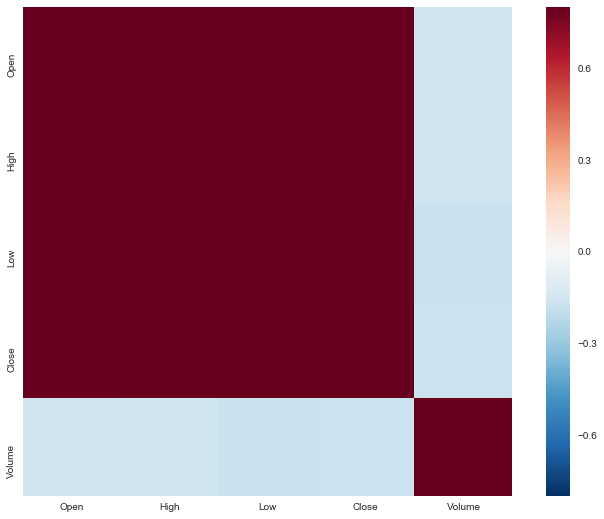

In [7]:
# Create a heatmap to compare the correlation of the columns.
import seaborn as sns

corrmat = data.corr()

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

As expected, the values are highly correlated. Creating prediction models based off of time-series data will not be helpful in reaching the goal of this project (to determine whether to buy or sell the at the next opening day). 

Features will need to be created to generate accurate predictions from the models. 

In [8]:
# The momentum will show how many days in a row the stock has moved up or down. 

# Create a list to store the momentum
momentum = [0]
i=1
# Calculate the momentums and store them in the new column, 'Momentum'
for row in data['Close']:
    if i < len(data):
        if data.Close[i] > data.Close[i-1]:
            momentum.append(+1)
            i = i+1
        elif data.Close[i] < data.Close[i-1]:
            momentum.append(-1)
            i = i+1

data['Momentum'] = momentum
data.head()

,Date,Open,High,Low,Close,Volume,Name,Momentum
0,8/13/2012,324.03,330.41,323.66,330.34,3268073,GOOGL,0
1,8/14/2012,329.95,336.76,329.83,334.66,3662178,GOOGL,1
2,8/15/2012,335.48,337.46,332.38,334.10,2411100,GOOGL,-1
3,8/16/2012,334.09,337.66,333.87,336.77,1717691,GOOGL,1
4,8/17/2012,337.40,338.96,336.19,338.91,2177896,GOOGL,1


In [9]:
# Print out the total momentum and the average momentum across all rows.
total_mom = sum(data.Momentum)
print(total_mom)
ave_mom = data.Momentum.mean()
print(ave_mom)

61
0.04848966613672496


In [10]:
streak = [0] * len(data)
i=1
# Calculate the streaks and store them in the new column, 'Streak'
for row in data['Close']:
    if i < len(data):
        if data.Close[i] > data.Close[i-1]:
            if streak[i-1] >= 0:
                streak[i] = streak[i-1]+1
                i = i+1
            else:
                streak[i]=0
                i = i+1
        elif data.Close[i] < data.Close[i-1]:
            if streak[i-1] <= 0:
                streak[i] = streak[i-1]-1
                i = i+1
            else:
                streak[i]=0
                i = i+1

data['Streak'] = streak
data.head()

,Date,Open,High,Low,Close,Volume,Name,Momentum,Streak
0,8/13/2012,324.03,330.41,323.66,330.34,3268073,GOOGL,0,0
1,8/14/2012,329.95,336.76,329.83,334.66,3662178,GOOGL,1,1
2,8/15/2012,335.48,337.46,332.38,334.10,2411100,GOOGL,-1,0
3,8/16/2012,334.09,337.66,333.87,336.77,1717691,GOOGL,1,1
4,8/17/2012,337.40,338.96,336.19,338.91,2177896,GOOGL,1,2


In [11]:
# Create a 'Future Momentum' feature that the model will attempt to predict.
data['Future Momentum'] = data.Momentum.shift(-1)
data.head()

,Date,Open,High,Low,Close,Volume,Name,Momentum,Streak,Future Momentum
0,8/13/2012,324.03,330.41,323.66,330.34,3268073,GOOGL,0,0,1.0
1,8/14/2012,329.95,336.76,329.83,334.66,3662178,GOOGL,1,1,-1.0
2,8/15/2012,335.48,337.46,332.38,334.10,2411100,GOOGL,-1,0,1.0
3,8/16/2012,334.09,337.66,333.87,336.77,1717691,GOOGL,1,1,1.0
4,8/17/2012,337.40,338.96,336.19,338.91,2177896,GOOGL,1,2,-1.0


In [12]:
data.tail()

,Date,Open,High,Low,Close,Volume,Name,Momentum,Streak,Future Momentum
1253,8/7/2017,947.52,948.96,943.50,945.75,1445754,GOOGL,-1,0,-1.0
1254,8/8/2017,944.29,952.49,942.48,944.19,1505064,GOOGL,-1,-1,-1.0
1255,8/9/2017,938.45,943.76,933.92,940.08,1400852,GOOGL,-1,-2,-1.0
1256,8/10/2017,935.00,936.30,921.78,923.59,2707393,GOOGL,-1,-3,1.0
1257,8/11/2017,923.71,933.36,921.22,930.09,1616708,GOOGL,1,0,NaN


In [13]:
# Drop the last row to get rid of the NaN values
data = data.iloc[:len(data)-1,:]

In [14]:
# Look at the tail to make sure the data looks good
data.tail()

,Date,Open,High,Low,Close,Volume,Name,Momentum,Streak,Future Momentum
1252,8/4/2017,943.95,947.54,939.80,945.79,1254574,GOOGL,1,1,-1.0
1253,8/7/2017,947.52,948.96,943.50,945.75,1445754,GOOGL,-1,0,-1.0
1254,8/8/2017,944.29,952.49,942.48,944.19,1505064,GOOGL,-1,-1,-1.0
1255,8/9/2017,938.45,943.76,933.92,940.08,1400852,GOOGL,-1,-2,-1.0
1256,8/10/2017,935.00,936.30,921.78,923.59,2707393,GOOGL,-1,-3,1.0


In [15]:
# Make a new dataframe to store the extra feature
new_data = data

# Make a feature for the ten day average
ten_ave = [0] * len(data)

# Calculate the ten day averages and store them in the new column, 'Ten Day Average'
for i in range(9,len(new_data)):
    ten_ave[i] = new_data.Close[i-9:i].mean()
    i=i+1

new_data['Ten Day Average'] = ten_ave

new_data.head()

C:\Users\maken\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,Date,Open,High,Low,Close,Volume,Name,Momentum,Streak,Future Momentum,Ten Day Average
0,8/13/2012,324.03,330.41,323.66,330.34,3268073,GOOGL,0,0,1.0,0.0
1,8/14/2012,329.95,336.76,329.83,334.66,3662178,GOOGL,1,1,-1.0,0.0
2,8/15/2012,335.48,337.46,332.38,334.10,2411100,GOOGL,-1,0,1.0,0.0
3,8/16/2012,334.09,337.66,333.87,336.77,1717691,GOOGL,1,1,1.0,0.0
4,8/17/2012,337.40,338.96,336.19,338.91,2177896,GOOGL,1,2,-1.0,0.0


In [16]:
# Drop the first nine rows to get rid of NaNs
new_data = new_data.iloc[9:,:]
new_data.head()

,Date,Open,High,Low,Close,Volume,Name,Momentum,Streak,Future Momentum,Ten Day Average
9,8/24/2012,338.14,340.57,337.38,339.65,1429267,GOOGL,1,0,-1.0,336.183333
10,8/27/2012,331.83,336.34,329.95,334.94,2614131,GOOGL,-1,-1,1.0,337.217778
11,8/28/2012,332.83,339.15,332.70,338.96,2058938,GOOGL,1,0,1.0,337.248889
12,8/29/2012,339.02,344.84,338.41,344.35,2991037,GOOGL,1,1,-1.0,337.788889
13,8/30/2012,342.46,344.04,340.43,341.18,1627704,GOOGL,-1,0,1.0,338.631111


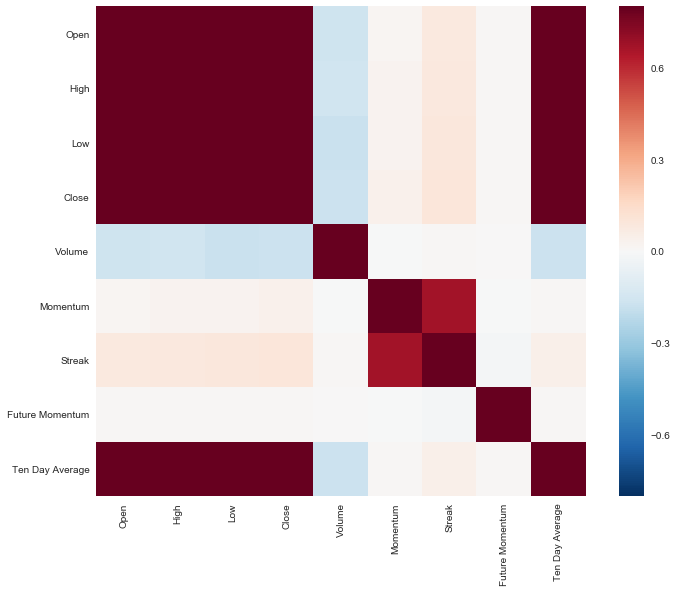

In [17]:
# Create a heatmap with the new features.

corrmat = new_data.corr()

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

# Section 2: Creation and Comparison of Predictive Models

Now that the data has been analyzed to ensure it can be manipulated, it is time to create some predictive models. For comparison, the scores from the models will be stored in a new table, titled "Model Comparison."

In [18]:
# Create a table to store the scores for each model.
# Title: Model Comparison
# Columns: Model, R^2, Accuracy, AUROC
# Model values: Linear Regression, Ridge Regression, Lasso Regression, Support Vector Regression, Gradient Boost Classification
models = {'Model':[], 'R^2':[], 'Accuracy':[], 'AUROC':[]}
columns = models.keys()
model_comparison = pd.DataFrame(data=models, columns=columns)
model_comparison

,Model,R^2,Accuracy,AUROC


In [19]:
# Set the variables. 
# Use the closing value for Y
# Use the new features for X
Y = data['Future Momentum']
X = data[['Close', 'Volume', 'Momentum', 'Streak']]

In [20]:
# Create new variables to include the ten day average
new_Y = new_data['Future Momentum']
new_X = new_data[['Close', 'Volume', 'Momentum', 'Streak','Ten Day Average']]

# Binary Logistic Regression Classifier

In [82]:
# Declare a logistic regression classifier.
# Larger C's lead to reduced regularization of parameters, but because there are
#   few features, the value of C has a trivial effect (tested for many C's)
lr = LogisticRegression(C=1e9)

# Make a dictionary to pass to the models_comparison dataframe
#lr1 = {'Model':'Logistic Regression 1', 'R^2':0, 'Accuracy':0,}

# Fit the model.
lr.fit(X,Y)
y_pred = lr.fit(X,Y).predict(X)

# Print the R-Squared value and store it in the table
print('R-Squared of the model:') 
score = r2_score(Y, y_pred)
print(score)
#lr1['R^2'] = score


# Print the accuracy of the model and store it in the table
print('Accuracy of the model:')
print(lr.score(X,Y))
#lr1['Accuracy'] = lr.score


print('Confusion Matrix of the model:')
conf_mat = confusion_matrix(Y, y_pred)
print(conf_mat)

# Print the AUROC.
cv = cross_val_score(lr, X, Y, cv=10, scoring='roc_auc') 
print('AUROC Score:')
print(cv)
# Print the average of the AUROC and store it in the table
print('Average of the AUROC Score:')
ave = sum(cv)/len(cv)
print(ave)
#lr1['AUROC'] = ave
#model_comparison.append(lr1)
models = {'Model':'Logistic Regression 1', 'R^2':score, 'Accuracy':lr.score,
         'AUROC':ave}
model_comparison.append(models)

R-Squared of the model:
-0.907435508346
Accuracy of the model:
0.524264120923
Confusion Matrix of the model:
[[  0 598]
 [  0 659]]
AUROC Score:
[ 0.52752525  0.40050505  0.57651515  0.5219697   0.37550505  0.52171717
  0.48535354  0.44242424  0.54648177  0.44067797]
Average of the AUROC Score:
0.483867488444


TypeError: Can only append a Series if ignore_index=True or if the Series has a name

In [22]:
print(y_pred)
print(y_pred.mean())

[ 1.  1.  1. ...,  1.  1.  1.]
1.0


# Analysis of Results for the First Logistic Regression Classifier:
R-Squared: A negative r2 value is indicative of the model being arbitrarily worse.

As seen above, the total momentum is +60 for 1258 rows of data, and the y_pred
value is always 1. 

Accuracy: The accuracy of the model is 52.4%.

Confusion Matrix: The matrix shows 598 False Positives and 659 True Positives.

Average AUROC: The average area under the curve is .483867... 

In [71]:
# Use Binary Logistic Regression again, but use the ten-day average.
# If the accuracy improves, it will show that the model can be improved.

# Make a dictionary to store the values
lr2 = {'Model':'Logistic Regression 2', 'R^2':0, 'Accuracy':0, 'AUROC':0}

# Fit the model.
lr.fit(new_X, new_Y)
y_pred = lr.fit(new_X,new_Y).predict(new_X)

# Print the R-Squared value and store it in the table
print('R-Squared of the model:') 
score = r2_score(new_Y, y_pred)
lr2['R^2'] = score
print(score)

# Print the accuracy of the model and store it in the table
print('Accuracy of the model:')
print(lr.score(new_X,new_Y))
# TODO: STORE IN TABLE
lr2['Accuracy'] = lr.score

print('Confusion Matrix of the model:')
conf_mat = confusion_matrix(new_Y, y_pred)
print(conf_mat)

# Print the AUROC.
cv = cross_val_score(lr, new_X, new_Y, cv=10, scoring='roc_auc') 
print('AUROC Score:')
print(cv)
# Print the average of the AUROC and store it in the table
print('Average of the AUROC Score:')
ave = sum(cv)/len(cv)
lr2['AUROC'] = ave
print(ave)

model_comparison.append(lr2)

R-Squared of the model:
-0.908256880734
Accuracy of the model:
0.524038461538
Confusion Matrix of the model:
[[  0 594]
 [  0 654]]
AUROC Score:
[ 0.51641414  0.42575758  0.58181818  0.49191919  0.37835724  0.55306389
  0.48474576  0.44328553  0.58670143  0.4440678 ]
Average of the AUROC Score:
0.490613073367


TypeError: Can only append a Series if ignore_index=True or if the Series has a name

In [24]:
print(y_pred)
print(y_pred.mean())

[ 1.  1.  1. ...,  1.  1.  1.]
1.0


# Analysis of Results for the Second Logistic Regression Classifier:
R-Squared: A negative r2 value is indicative of the model being arbitrarily worse.

Accuracy: The accuracy of the model is 52.4%.

Confusion Matrix: The matrix shows 594 False Positives and 654 True Positives.

Average AUROC: The average area under the curve is .406... 

### Ridge Regression Classifier

In [25]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced. Note that by convention, the
# intercept is not regularized. Since we standardized the data
# earlier, the intercept should be equal to zero and can be dropped.

ridgeregr = linear_model.Ridge(alpha=10, fit_intercept=False) 
ridgeregr.fit(X, Y)

y_pred = ridgeregr.fit(X,Y).predict(X)

# Print the R-Squared value and store it in the table
print('R-Squared of the model:') 
score = r2_score(Y, y_pred)
print(score)

# Print the accuracy of the model and store it in the table
print('Accuracy of the model:')
print(ridgeregr.score(X,Y))
# TODO: STORE IN TABLE

"""
print('Confusion Matrix of the model:')
conf_mat = confusion_matrix(Y, y_pred)
print(conf_mat)
"""
# Print the AUROC.
cv = cross_val_score(ridgeregr, X, Y, cv=10, scoring='roc_auc') 
print('AUROC Score:')
print(cv)
# Print the average of the AUROC and store it in the table
print('Average of the AUROC Score:')
print(sum(cv)/len(cv))
# TODO: STORE IN TABLE

R-Squared of the model:
0.000417011761739
Accuracy of the model:
0.000417011761739
AUROC Score:
[ 0.53017241  0.44228831  0.52979798  0.53099798  0.51159274  0.50912779
  0.47331141  0.44724653  0.47720287  0.3513302 ]
Average of the AUROC Score:
0.480306822224


In [26]:
print(y_pred)
print(y_pred.mean())

[ 0.03578161  0.03574146  0.02117346 ...,  0.07192826  0.0845071
  0.10206515]
0.0477904672036


# Analysis of Results for the First Ridge Regression Classifier:
R-Squared: 

Accuracy: 

Confusion Matrix: 

Average AUROC: 

In [27]:
# Use Ridge Regression again, but use the ten-day average.
# If the accuracy improves, it will show that the model can be improved.

##### Make sure you fit with the correct data and update the scoring metrics

ridgeregr.fit(new_X, new_Y)
y_pred = ridgeregr.fit(new_X,new_Y).predict(new_X)

# Print the R-Squared value and store it in the table
print('R-Squared of the model:') 
score = r2_score(new_Y, y_pred)
print(score)

# Print the accuracy of the model and store it in the table
print('Accuracy of the model:')
print(ridgeregr.score(new_X,new_Y))
# TODO: STORE IN TABLE

"""
print('Confusion Matrix of the model:')
conf_mat = confusion_matrix(new_Y, y_pred)
print(conf_mat)
"""
# Print the AUROC.
cv = cross_val_score(ridgeregr, new_X, new_Y, cv=10, scoring='roc_auc') 
print('AUROC Score:')
print(cv)
# Print the average of the AUROC and store it in the table
print('Average of the AUROC Score:')
print(sum(cv)/len(cv))
# TODO: STORE IN TABLE

R-Squared of the model:
0.0016389209226
Accuracy of the model:
0.0016389209226
AUROC Score:
[ 0.45536636  0.46307692  0.55687082  0.51357582  0.57066052  0.59752322
  0.47220793  0.55223881  0.50911458  0.37671958]
Average of the AUROC Score:
0.506735455214


In [28]:
print(y_pred)
print(y_pred.mean())

[ 0.03422879  0.02882705  0.0408703  ...,  0.07887133  0.08419232
  0.12764107]
0.0476211119218


# Analysis of Results for the Second Ridge Regression Classifier:
R-Squared: 

Accuracy: 

Confusion Matrix: 

Average AUROC: 

# Lasso Regression Classifier

In [29]:
lasso = linear_model.Lasso(alpha=.35)
lasso.fit(X, Y)

y_pred = lasso.fit(X,Y).predict(X)

# Print the R-Squared value and store it in the table
print('R-Squared of the model:') 
score = r2_score(Y, y_pred)
print(score)

# Print the accuracy of the model and store it in the table
print('Accuracy of the model:')
print(lasso.score(X,Y))
# TODO: STORE IN TABLE

"""
print('Confusion Matrix of the model:')
conf_mat = confusion_matrix(Y, y_pred)
print(conf_mat)
"""
# Print the AUROC.
cv = cross_val_score(lasso, X, Y, cv=10, scoring='roc_auc') 
print('AUROC Score:')
print(cv)
# Print the average of the AUROC and store it in the table
print('Average of the AUROC Score:')
print(sum(cv)/len(cv))
# TODO: STORE IN TABLE

R-Squared of the model:
3.58369809751e-05
Accuracy of the model:
3.58369809751e-05
AUROC Score:
[ 0.52890467  0.42111895  0.5270202   0.41355847  0.45262097  0.52890467
  0.46142171  0.43232115  0.47464139  0.44653104]
Average of the AUROC Score:
0.468704320916


In [30]:
print(y_pred)
print(y_pred.mean())

[ 0.04302036  0.04367439  0.04192738 ...,  0.05594064  0.05569343
  0.05709057]
0.0485282418457


# Analysis of Results for the First Lasso Regression Classifier:
R-Squared: 

Accuracy: 

Confusion Matrix: 

Average AUROC: 

In [31]:
lasso.fit(new_X, new_Y)

y_pred = lasso.fit(new_X,new_Y).predict(new_X)

# Print the R-Squared value and store it in the table
print('R-Squared of the model:') 
score = r2_score(new_Y, y_pred)
print(score)

# Print the accuracy of the model and store it in the table
print('Accuracy of the model:')
print(lasso.score(new_X,new_Y))
# TODO: STORE IN TABLE

"""
print('Confusion Matrix of the model:')
conf_mat = confusion_matrix(new_Y, y_pred)
print(conf_mat)
"""
# Print the AUROC.
cv = cross_val_score(lasso, new_X, new_Y, cv=10, scoring='roc_auc') 
print('AUROC Score:')
print(cv)
# Print the average of the AUROC and store it in the table
print('Average of the AUROC Score:')
print(sum(cv)/len(cv))
# TODO: STORE IN TABLE

R-Squared of the model:
0.000115556606135
Accuracy of the model:
0.000115556606135
AUROC Score:
[ 0.5250258   0.42333333  0.52959341  0.41060451  0.46748592  0.53224974
  0.46603191  0.42794647  0.49817708  0.37751323]
Average of the AUROC Score:
0.465796140946


In [32]:
print(y_pred)
print(y_pred.mean())

[ 0.03178294  0.03457972  0.03329652 ...,  0.06441369  0.06404839
  0.06699899]
0.0480769230769


# Analysis of Results for the Second Lasso Regression Classifier:
R-Squared: 

Accuracy: 

Confusion Matrix: 

Average AUROC: 

# Support Vector Regression

In [81]:
# TODO: Look up the epsilon value for SVR
# Changing value for epsilon may reduce the overfitting

# Make a model using SVR here
svr = SVR(epsilon=.5)
svr.fit(X,Y)
y_pred = lasso.fit(X,Y).predict(X)

# Print the R-Squared value and store it in the table
print('R-Squared of the model:') 
score = r2_score(Y, y_pred)
print(score)

# Print the accuracy of the model and store it in the table
print('Accuracy of the model:')
print(svr.score(X,Y))
# TODO: STORE IN TABLE


#print('Confusion Matrix of the model:')
#conf_mat = confusion_matrix(Y, y_pred)
#print(conf_mat)

# Print the AUROC.
cv = cross_val_score(svr, X, Y, cv=10, scoring='roc_auc') 
print('AUROC Score:')
print(cv)
# Print the average of the AUROC and store it in the table
print('Average of the AUROC Score:')
print(sum(cv)/len(cv))
# TODO: STORE IN TABLE

R-Squared of the model:
3.58369809751e-05
Accuracy of the model:
0.749417240786
AUROC Score:
[ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]
Average of the AUROC Score:
0.5


In [34]:
print(y_pred)
print(y_pred.mean())

[ 0.04302036  0.04367439  0.04192738 ...,  0.05594064  0.05569343
  0.05709057]
0.0485282418457


# Analysis of Results for the First Support Vector Regression Model:
R-Squared: 

Accuracy: 

Confusion Matrix: 

Average AUROC: 

In [35]:
svr.fit(new_X,new_Y)
y_pred = svr.fit(new_X,new_Y).predict(new_X)

# Print the R-Squared value and store it in the table
print('R-Squared of the model:') 
score = r2_score(new_Y, y_pred)
print(score)

# Print the accuracy of the model and store it in the table
print('Accuracy of the model:')
print(svr.score(new_X,new_Y))
# TODO: STORE IN TABLE

"""
print('Confusion Matrix of the model:')
conf_mat = confusion_matrix(new_Y, y_pred)
print(conf_mat)
"""
# Print the AUROC.
cv = cross_val_score(svr, new_X, new_Y, cv=10, scoring='roc_auc') 
print('AUROC Score:')
print(cv)
# Print the average of the AUROC and store it in the table
print('Average of the AUROC Score:')
print(sum(cv)/len(cv))
# TODO: STORE IN TABLE

R-Squared of the model:
0.98998259545
Accuracy of the model:
0.98998259545
AUROC Score:
[ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]
Average of the AUROC Score:
0.5


In [36]:
print(y_pred)
print(y_pred.mean())

[-0.89969952  0.90030048  0.90030048 ..., -0.90048077 -0.90048077
  0.90030048]
0.0432692307692


# Analysis of Results for the Second Support Vector Regression Model:
R-Squared: 

Accuracy: 

Confusion Matrix: 

Average AUROC: 

## Talk about overfitting

# Support Vector Classifier

In [77]:
# TODO: Look up the epsilon value for SVC
# Epsilon in the epsilon-SVR model. It specifies the epsilon-tube within 
# which no penalty is associated in the training loss function with points 
# predicted within a distance epsilon from the actual value.

########## NOTE: SVC did not like being passed epsilon=_ value

# Make a model using SVR here
svc = SVC()
svc.fit(X,Y)
y_pred = svc.fit(X,Y).predict(X)

# Print the R-Squared value and store it in the table
print('R-Squared of the model:') 
score = r2_score(Y, y_pred)
print(score)

# Print the accuracy of the model and store it in the table
print('Accuracy of the model:')
print(svc.score(X,Y))
# TODO: STORE IN TABLE


print('Confusion Matrix of the model:')
conf_mat = confusion_matrix(Y, y_pred)
print(conf_mat)

# Print the AUROC.
cv = cross_val_score(svc, X, Y, cv=10, scoring='roc_auc') 
print('AUROC Score:')
print(cv)
# Print the average of the AUROC and store it in the table
print('Average of the AUROC Score:')
print(sum(cv)/len(cv))
# TODO: STORE IN TABLE

R-Squared of the model:
1.0
Accuracy of the model:
1.0
Confusion Matrix of the model:
[[598   0]
 [  0 659]]
AUROC Score:
[ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]
Average of the AUROC Score:
0.5


In [38]:
print(y_pred)
print(y_pred.mean())

[ 1. -1.  1. ..., -1. -1.  1.]
0.0485282418457


# Analysis of Results for the First Support Vector Classifier:
R-Squared: 

Accuracy: 

Confusion Matrix: 

Average AUROC: 

In [39]:
svc.fit(new_X,new_Y)
y_pred = svc.fit(new_X,new_Y).predict(new_X)

# Print the R-Squared value and store it in the table
print('R-Squared of the model:') 
score = r2_score(new_Y, y_pred)
print(score)

# Print the accuracy of the model and store it in the table
print('Accuracy of the model:')
print(svc.score(new_X, new_Y))
# TODO: STORE IN TABLE


print('Confusion Matrix of the model:')
conf_mat = confusion_matrix(new_Y, y_pred)
print(conf_mat)

# Print the AUROC.
cv = cross_val_score(svc, new_X, new_Y, cv=10, scoring='roc_auc') 
print('AUROC Score:')
print(cv)
# Print the average of the AUROC and store it in the table
print('Average of the AUROC Score:')
print(sum(cv)/len(cv))
# TODO: STORE IN TABLE

R-Squared of the model:
1.0
Accuracy of the model:
1.0
Confusion Matrix of the model:
[[594   0]
 [  0 654]]
AUROC Score:
[ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]
Average of the AUROC Score:
0.5


In [40]:
print(y_pred)
print(y_pred.mean())

[-1.  1.  1. ..., -1. -1.  1.]
0.0480769230769


# Analysis of Results for the Second Support Vector Clasifier:
R-Squared: 

Accuracy: 

Confusion Matrix: 

Average AUROC: 

# Gradient Boosting Classifier

In [78]:
# 500 iterations, using 5-deep trees, and loss function 'deviance.'
# Play around with number of iterations
# Look into learning rate
params = {'n_estimators': 500,
          'max_depth': 5,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X,Y)
y_pred = clf.fit(X,Y).predict(X)

# Print the R-Squared value and store it in the table
print('R-Squared of the model:') 
score = r2_score(Y, y_pred)
print(score)

# Print the accuracy of the model and store it in the table
print('Accuracy of the model:')
print(clf.score(X,Y))
# TODO: STORE IN TABLE


print('Confusion Matrix of the model:')
conf_mat = confusion_matrix(Y, y_pred)
print(conf_mat)

# Print the AUROC.
cv = cross_val_score(clf, X, Y, cv=10, scoring='roc_auc') 
print('AUROC Score:')
print(cv)
# Print the average of the AUROC and store it in the table
print('Average of the AUROC Score:')
print(sum(cv)/len(cv))
# TODO: STORE IN TABLE

R-Squared of the model:
1.0
Accuracy of the model:
1.0
Confusion Matrix of the model:
[[598   0]
 [  0 659]]
AUROC Score:
[ 0.60896465  0.40328283  0.5479798   0.4729798   0.49659091  0.40290404
  0.40984848  0.51868687  0.4517206   0.54119948]
Average of the AUROC Score:
0.485415744801


# Notes:
High variation in cv score, indicative of overfitting. Solid r-squared and accuracy.

After playing around with different n_estimators and max_depth values, need to determine the best tradeoff for r-squared & accuracy vs AUROC variations.

In [50]:
print(y_pred)
print(y_pred.mean())

[ 1.  1.  1. ...,  1.  1.  1.]
0.498806682578


# Analysis of Results for the First Gradient Boost Model:
R-Squared: 

Accuracy: 

Confusion Matrix: 

Average AUROC: 

In [61]:
clf.fit(new_X,new_Y)
y_pred = clf.fit(new_X,new_Y).predict(new_X)

# Print the R-Squared value and store it in the table
print('R-Squared of the model:') 
score = r2_score(new_Y, y_pred)
print(score)

# Print the accuracy of the model and store it in the table
print('Accuracy of the model:')
print(clf.score(new_X,new_Y))
# TODO: STORE IN TABLE


print('Confusion Matrix of the model:')
conf_mat = confusion_matrix(new_Y, y_pred)
print(conf_mat)

# Print the AUROC.
cv = cross_val_score(clf, new_X, new_Y, cv=10, scoring='roc_auc') 
print('AUROC Score:')
print(cv)
# Print the average of the AUROC and store it in the table
print('Average of the AUROC Score:')
print(sum(cv)/len(cv))
# TODO: STORE IN TABLE

R-Squared of the model:
1.0
Accuracy of the model:
1.0
Confusion Matrix of the model:
[[594   0]
 [  0 654]]
AUROC Score:
[ 0.51944444  0.4344697   0.5209596   0.42676768  0.48292047  0.38539765
  0.44511082  0.47183833  0.44863103  0.53898305]
Average of the AUROC Score:
0.467452277007


In [44]:
print(y_pred)
print(y_pred.mean())

[-1.  1.  1. ...,  1. -1.  1.]
0.129807692308


# Analysis of Results for the Second Gradient Boost Model:
R-Squared: 

Accuracy: 

Confusion Matrix: 

Average AUROC: 

# Section 3: Selection and Analysis of the Best Performing Model

Display the model comparison table here. Write up an analysis. 

In [94]:
model_comparison

,Model,R^2,Accuracy,AUROC


Analysis of table goes here. 

# Compare the models to each other as well as to the results of buying each week 401k style.

In [93]:
# Create a method to calculate return for the prediction models
# First, create a dataframe to store the average return for each model:
returns = {'Model':[],'Average Return Over Time':[]}
columns = returns.keys()
pred_returns = pd.DataFrame(data=returns, columns=columns)

# Create a cash_available list that stores how much cash is available 
# to buy the stocks
cash_available = [10000]

# Start with $10k in cash, do not allow the model to go below $2k 
# The max value of stock in dataframe is $1005, $2k will provide a 
# pain tolerance so that, in the event of a bad buy action, 
# there is still money to buy stocks at the next opportunity


# Create a buy_stock function that buys as many stocks as can be afforded
def buy_stock(model):
    # Only buy when cash_availalbe greater than $2k
    if cash_available > 2000:
        # Set number of stocks to buy
        ### Need to ensure that cash_available does not drop below $2k
        num_stocks_buy[i] = cash_available[i-1]/data.Close[i]
        stocks_owned[i] = stocks_owned[i-1]+num_stocks_buy
        # Subtract from cash_available
        cash_available[i] = cash_available[i-1]-num_stocks_buy[i]*data.Close[i]
        return(cahs_available[i], stocks_owned[i])
        
# Create a sell_stock function that sells all stocks
def sell_stock(model):
    sell_value = stocks_owned[i]*data.Close[i]
    cash_available[i] = cash_available[i-1] + sell_value
    stocks_owned[i] = 0
    return(cash_available[i], stocks_owned[i])

def pred_return(model, y_pred):
    i = 0
    for i in range(len(X)):
        # If the predicted value is greater than zero, buy more stock
        if y_pred[i] > 0:
            buy_stock(model)
        # If the predicted value is less than zero, sell stock
        elif y_pred[i] < 0:
            sell_stock(model)
        # Store the new values in the table
        
# Create the 401k approach simulator, safe_invest, 
# That buys as much stock as is available every two weeks / ten business days.
def safe_invest(data):
    i=10
    # $10k initial cash for prediction model approach / 6 years of data / 
    # 26 bi-weekly 401k additions = $76 every two weeks
    cash_available = 76
    for i in range(data):
        num_stocks_buy[i] = cash_available[i-1]/data.Close[i]
        stocks_owned[i] = num_stocks_buy[i] + stocks_owned[i-1]
        # Store the values in a table